## 1. Tracking a changing climate
<p>The climate is changing around the world. The impacts of climate change are felt in many different areas, but they are particularly noticeable in their effects on birds. Many bird species are moving north, if they can,  to stay in climatic conditions that are suitable for them.</p>
<p>Our analysis will use data from the <a href="https://www.metoffice.gov.uk/climate/uk/data/ukcp09">UK Met Office</a> together with records from the <a href="https://www.gbif.org/">Global Biodiversity Information Facility</a> to build our very own species distribution model using machine learning. This model will be able to predict where our bird species of interest is likely to occur in the future - information that is invaluable to conservation organization working on the ground to preserve these species and save them from extinction!</p>
<p>In this notebook, we will model the Scottish crossbill (<em>Loxia scotica</em>). The Scottish crossbills is a small bird that inhabits the cool Scottish forests and feeds on pine seeds. Only ~ 20,000 individuals of this species are alive today. The code and the data sources in this project can be reapplied to any other species we may be interested in studying.</p>
<p><img src="https://assets.datacamp.com/production/project_664/img/Loxia.jpg" alt="Loxia.jpg"></p>
<p>We will start by importing the climate data from a local <code>rds</code> file.</p>

In [17]:
# Load in the tidyverse, raster, and sf packages
library(tidyverse)
library(raster)
library(sf)

# Read the climate data from an rds file
climate  <- read_rds("datasets/climate_raster.rds")

# Have a look at the variables in the climate data
colnames(climate)

# Convert to SpatialPixelDataFrame for plotting
climate_df <- mutate(
  .data = climate, 
  rasters = map(
    .x = rasters, 
    ~ as_tibble(as(.x, "SpatialPixelsDataFrame")))) %>%
  unnest(cols = c(rasters))

[1] "decade"  "rasters"

## 2. Mapping a changing climate
<p>We have loaded the pre-processed climate data and converted it to a <code>SpatialPixelDataFrame</code>. This data frame now contains all the information we need:</p>
<ul>
<li>the <code>decade</code> of observation,</li>
<li>spatial coordinates (<code>x</code>, <code>y</code>)</li>
<li>six selected climatic variables (<code>minimum.temperature</code>, <code>maximum.temperature</code>, <code>rainfall</code>, <code>wind.speed</code>, <code>snow.lying</code>, <code>air.frost</code>)</li>
</ul>
<p>An excellent first step in any analysis is visualizing the data. Visualizing the data makes sure the data import worked, and it helps us develop intuition about the patterns in our dataset. Here we are dealing with spatial data - let us create maps! We will start with two maps: one map of the climatic conditions in 1970, and one map of the climatic conditions in 2010. Our climate data has several variables, so let us pick <code>minimum.temperature</code> for now.</p>

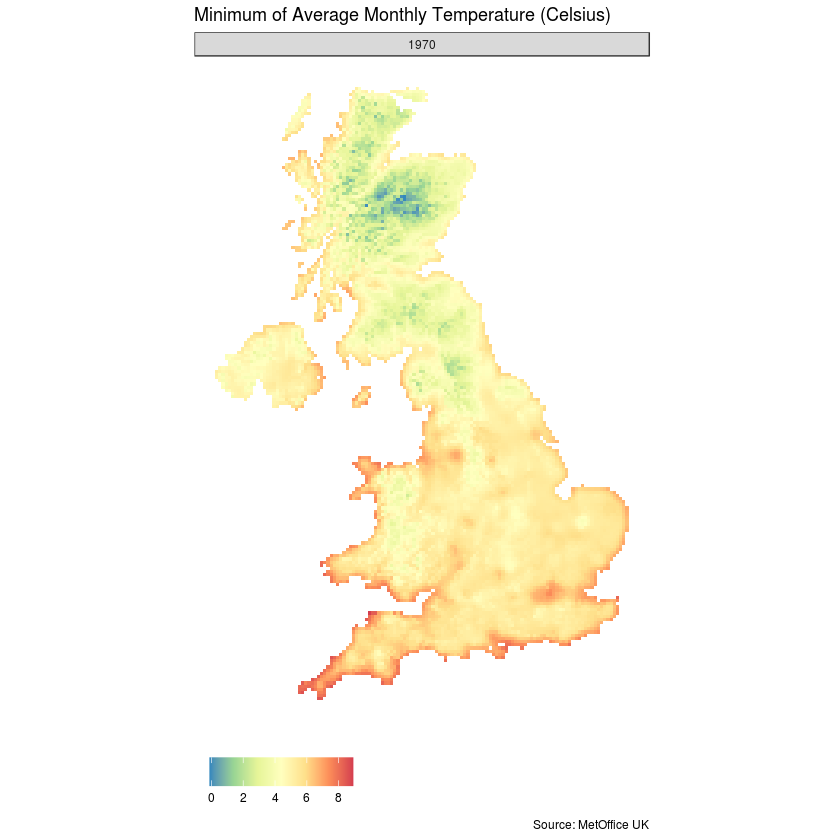

In [19]:
library(ggthemes)

# Filter the data to plot
ggp_temperature <- climate_df %>%
  filter(decade %in% c(1970)) %>% 
  # Create the plot
  ggplot(aes(x = x, y = y)) + geom_tile(aes(fill = minimum.temperature)) +
  # Style the plot with options ideal for maps
  theme_map() + coord_equal() +
  facet_grid(~ decade) + scale_fill_distiller(palette = "Spectral") + 
  theme(legend.title = element_blank(), legend.position = "bottom") +
  labs(title = "Minimum of Average Monthly Temperature (Celsius)", caption = 'Source: MetOffice UK')

# Display the map
ggp_temperature

## 3. Fieldwork in the digital age – download the data
<p>Now we need to obtain species occurrence records. This used to be the main challenge in biogeography. Natural historians, such as Charles Darwin and Alexander von Humboldt, traveled around the globe for years on rustic sail ships collecting animal and plant specimens to understand the natural world. Today, we stand on the shoulders of giants. Getting data is fast and easy thanks to two organizations:</p>
<ul>
<li><p><a href="https://www.gbif.org/">The Global Biodiversity Information Facility (GBIF)</a>, an international network and research infrastructure aimed at providing anyone, anywhere, open access to data about life on Earth. We will use their data in this project.</p></li>
<li><p><a href="https://ropensci.org/">rOpenSci</a>, a non-profit initiative that develops open source tools for academic data sets. Their package <code>rgbif</code> will help us access the species data.</p></li>
</ul>

In [21]:
library(rgbif)
source("datasets/occ_search.R")

# Call the API to get the occurrence records of this species
gbif_response <- occ_search(
  scientificName = "Loxia scotica", country = "GB",
  hasCoordinate = TRUE, hasGeospatialIssue = FALSE, limit = 2000)

# Inspect the class and names of gbif_response
class(gbif_response)
names(gbif_response)

# Print the first six lines of the data element in gbif_response
head(gbif_response[["data"]])

[1] "gbif"

[1] "meta"      "hierarchy" "data"      "media"     "facets"

key,scientificName,decimalLatitude,decimalLongitude,issues,datasetKey,publishingOrgKey,networkKeys,installationKey,publishingCountry,...,preparations,institutionID,continent,samplingEffort,footprintWKT,endDayOfYear,datasetName,taxonID,ownerInstitutionCode,startDayOfYear
2156651144,"Loxia scotica Hartert, 1904",57.23882,-3.712113,cdround,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,none,7182d304-b0a2-404b-baba-2086a325c221,GB,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2164584410,"Loxia scotica Hartert, 1904",57.24274,-3.672178,cdround,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,none,7182d304-b0a2-404b-baba-2086a325c221,GB,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2190199121,"Loxia scotica Hartert, 1904",57.29586,-3.792071,cdround,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,none,7182d304-b0a2-404b-baba-2086a325c221,GB,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2171018152,"Loxia scotica Hartert, 1904",57.22461,-3.628069,cdround,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,none,7182d304-b0a2-404b-baba-2086a325c221,GB,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2170795732,"Loxia scotica Hartert, 1904",57.71175,-4.306472,cdround,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,none,7182d304-b0a2-404b-baba-2086a325c221,GB,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2170941690,"Loxia scotica Hartert, 1904",57.71175,-4.306472,cdround,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,e2e717bf-551a-4917-bdc9-4fa0f342c530,none,7182d304-b0a2-404b-baba-2086a325c221,GB,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## 4. Sorting out the bad eggs – data cleaning
<p>GBIF and rOpenSci just saved us years of roaming around the highlands with a pair of binoculars, camping in mud, rain, and snow, and chasing crossbills through the forest! Nevertheless, it is still up to us to make sense of the data. In particular, data collected at this large scale can have issues. Luckily, GBIF provides some useful metadata on each record.</p>
<p>Here are some criteria we can use: </p>
<ol>
<li>"issues" - We will only use records where no doubts about the observation were listed.</li>
<li>"license" - We will only use records under a creative commons license.</li>
<li>"date" - We will only use records between 1965 and 2015 because that matches our climate dataset.</li>
</ol>

In [23]:
library(lubridate)

birds_dated <- mutate(
  .data = gbif_response$data,
  # Create a new column specifying the decade of observation
  decade = ymd_hms(eventDate) %>% round_date("10y") %>% year())

birds_cleaned <- birds_dated %>%
  filter(
    issues == "" &
    str_detect(license, "http://creativecommons.org/") &
    # No records before 1970s decade or after 2010s decade
    decade >= 1970 & decade <= 2010
  ) %>%
  transmute(decade = decade, x = decimalLongitude, y = decimalLatitude) %>%
  arrange(decade)

## 5. Nesting the data
<p>We have cleaned the data, but there is a problem. We want to know the climatic conditions at the location of the bird observation <strong>at the time</strong> of the observation. This is tricky because we have climate data from multiple decades. How do we match each bird observation to the correct climate raster cell?</p>
<p>We will use a nifty trick: we can <code>nest()</code> data in a list column. The result is a data frame where the grouping columns do not change, and a list column of aggregated data from each group is added. List columns can hold many different kinds of variables such as vectors, data frames, and even objects. For example, the climate data that we imported earlier was already nested by decade and had a list column (<code>rasters</code>) that contained a <code>rasterStack</code> object for each decade.</p>

In [25]:
# "Nest" the bird data
birds_nested <- birds_cleaned %>% 
  group_by(decade) %>% 
  nest(.key = "presences")

head(birds_nested)

# Calculate the total number of records per decade
birds_counted <- birds_nested %>%
  mutate(n = map_dbl(.x = presences, .f = nrow))

head(birds_counted)

decade,presences
1970,"-3.7742, -3.7996, -3.7424, -3.7742, -3.7536, 57.1484, 57.1748, 57.1368, 57.1484, 57.2490"
1980,"-3.805402, -3.604524, -4.323717, -3.712700, 57.164144, 57.327101, 56.670186, 57.163600"
1990,"-3.957270, -3.626685, -3.702624, -3.957270, -3.957270, -3.604524, -3.680281, -3.175040, -3.604524, 54.930540, 57.227079, 57.241025, 54.930540, 54.930540, 57.327101, 57.236949, 57.043710, 57.327101"


decade,presences,n
1970,"-3.7742, -3.7996, -3.7424, -3.7742, -3.7536, 57.1484, 57.1748, 57.1368, 57.1484, 57.2490",5
1980,"-3.805402, -3.604524, -4.323717, -3.712700, 57.164144, 57.327101, 56.670186, 57.163600",4
1990,"-3.957270, -3.626685, -3.702624, -3.957270, -3.957270, -3.604524, -3.680281, -3.175040, -3.604524, 54.930540, 57.227079, 57.241025, 54.930540, 54.930540, 57.327101, 57.236949, 57.043710, 57.327101",9


## 6. Making things spatial - projecting our observations
<p>Excellent! Both our datasets are nested by decade now. We have one more step before we extract the climatic conditions at bird locations. Locations in <code>birds_counted</code> are latitude and longitude coordinates. R doesn't know that these are spatial information. We need to <strong>convert</strong> and <strong>project</strong> our data.</p>
<p>Projections are necessary because maps are 2-dimensional, but the earth is 3-dimensional. There is no entirely accurate way to represent the surface of a 3D sphere in 2D. Projections are sets of conventions to help us with this issue. GBIF hosts data from around the world and uses a global projection (WGS84). The Met Office is a UK organization and provides data in the British National Grid projection (BNG).</p>
<p>To project spatial data, use Coordinate Reference System (CRS) strings.</p>

In [27]:
# Define geographical projections
proj_latlon <- st_crs("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
proj_ukgrid <- st_crs("+init=epsg:27700")

# Convert records to spatial points and project them
birds_presences <- mutate(birds_counted,
  presences = map(presences, ~ .x %>%
    # Specify the current projection
    st_as_sf(coords = c("x", "y"), crs = proj_latlon) %>%
    # Transform to new projection
    st_transform(crs = proj_ukgrid)))

## 7. Extract exactly what we want
<p>Now we are ready to combine the two datasets and extract the climatic conditions at each location for the given decade. This is where the nested structure comes in handy! We join the data frames by their grouping column and can rest assured that the data in the list columns are matched up correctly. This allows us to operate on the list column variables element-wise using the <code>map()</code> family functions.</p>

In [29]:
# Combine the bird data and the climate data in one data frame
birds_climate <- full_join(birds_presences, climate, by = "decade")

presence_data <- map2_df(
  .x = birds_climate[["rasters"]],
  .y = birds_climate[["presences"]],
  # extract the raster values at presence locations
  ~ raster::extract(x=.x, y=.y) %>% 
    as_tibble() %>% 
    mutate(observation = "presence"))

## 8. Pseudo-absences
<p>To run a machine learning model, the classification algorithm needs two classes: presences and absences. Our presences are the observations from GBIF. Absences are a lot harder to get.</p>
<p>The difficulty is because of information asymmetry between the presences and absences. With a bird observation we are sure it occurred at that location, but to be certain the bird does <strong>not</strong> occur somewhere, we would have to continuously monitor the site.</p>
<p>One way to deal with this problem is to generate "pseudo-absences". Pseudo-absences are a random sample from the entire study area. We assume that the species does not occur at the random locations and our hope is that the average actual probability of occurrence for the bird in these random locations is low enough to give our algorithm something to learn</p>

In [31]:
# Define helper function for creating pseudo-absence data
create_pseudo_absences <- function(rasters, n, ...) {
    set.seed(12345)
    sampleRandom(rasters, size = n * 5, sp = TRUE) %>% 
    raster::extract(rasters, .) %>% as_tibble() %>%
    mutate(observation = "pseudo_absence")
}

# Create pseudo-absence proportional to the total number of records per decade
pseudo_absence_data <- pmap_df(.l = birds_climate, .f = create_pseudo_absences)

# Combine the two datasets
model_data <- bind_rows(presence_data, pseudo_absence_data) %>%
  mutate(observation = factor(observation)) %>% na.omit()

## 9. Making models - with caret
<p>We are ready to train our model. We will use <code>glmnet</code>,  which fits a generalized logistic regression (<em>glm</em>) with elastic net regularization (<em>net</em>). Our algorithm has several "hyperparameters". These are variables used by the machine learning algorithm to learn from the data. They influence the performance of the model and often interact with one another, so it is difficult to know the right settings <em>apriori</em>.</p>
<p>To figure out a good set of hyperparameters, we need to try several possible scenarios to see which ones work best. <code>caret</code> makes this easy. All we need to do is define a "tuning grid" with sets of possible values for each training parameter. Then use cross-validation to evaluate how well the different combinations of hyperparameters did building the predictive model.</p>

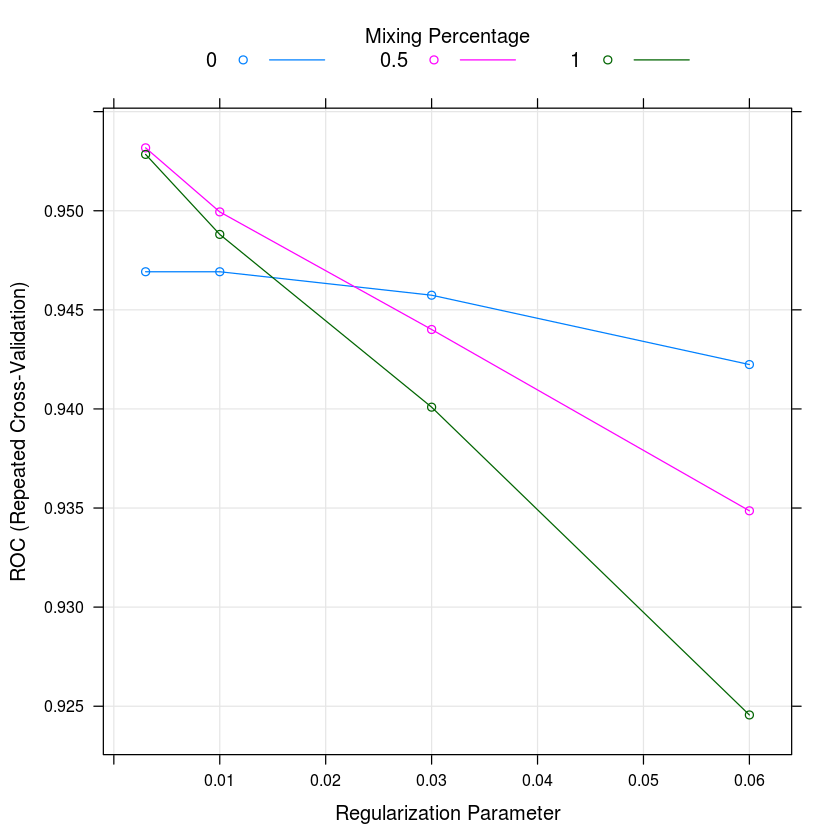

In [33]:
# Load caret and set a reproducible seed
library(caret)
set.seed(12345)

# Create a tuning grid with sets of hyperparameters to try
tuneGrid <- expand.grid(alpha = c(0, 0.5, 1), lambda = c(.003, .01, .03, .06))

# Create settings for model training
trControl <- trainControl(method = 'repeatedcv', number = 5, repeats = 1,
  classProbs = TRUE, verboseIter = FALSE, summaryFunction = twoClassSummary)

# Fit a statistical model to the data and plot
model_fit <- train(
  observation ~ ., data = model_data,
  method = "glmnet", family = "binomial", metric = "ROC",
  tuneGrid = tuneGrid, trControl = trControl)

plot(model_fit)

## 10. Prediction probabilities
<p>Congratulations, we have built our first species distribution model! Next, we will use it to predict the probability of occurrence for our little crossbill across the UK! We will make a prediction for each decade and each cell of the grid. Since we fit a logistic regression model, we can choose to predict the probability. In our case, this becomes the "probability of occurrence" for our species.</p>

In [35]:
# Use our model to make a prediction
climate_df[["prediction"]] <- predict(
    object = model_fit,
    newdata = climate_df,
    type = "prob")[["presence"]]

head(climate_df)

decade,minimum.temperature,maximum.temperature,rainfall,wind.speed,snow.lying,air.frost,x,y,prediction
1970,5.180083,9.764917,101.50867,14.66736,0.888750,2.541167,227500,972500,0.03820425
1970,4.422417,8.400500,119.00492,18.30500,1.768333,3.757833,232500,972500,0.04426503
1970,5.199667,10.947667,74.00758,12.15764,1.241000,3.136417,307500,972500,0.10089482
1970,4.771250,10.619250,71.86208,11.51333,1.569750,4.126000,322500,972500,0.21359648
1970,5.486250,10.478667,92.30558,11.77028,1.107833,2.875833,222500,967500,0.06564189
1970,4.464667,9.324833,114.34383,15.10250,1.477417,4.422417,227500,967500,0.05684158


## 11. A map says more than a thousand words
<p>We have our predictions, but they are not in a digestible format. It is tough to figure out what is going on from that large table of numbers, and it would be even more challenging to convince a politician, the general public, or a local decision maker with it.</p>
<p>It would be great to visualize the predictions so we can see the patterns and how they change over time. A picture says more than a thousand words. And what says even more than a picture (at least if you are a geographer)? A colored map! Let us create another map that shows our predictions of a changing climate in the UK, from 1965 to 2015.</p>

In [38]:
library(viridis)

# Create the plot
ggp_changemap <- ggplot(data=climate_df, aes(x=x, y=y, fill=prediction) + 
  geom_tile() +
  # Style the plot with the appropriate settings for a map
  theme_map() + coord_equal() +
  scale_fill_viridis(option = "A") + theme(legend.position = "bottom") +
  # Add faceting by decade
  facet_grid(~ decade) +
  labs(title = 'Habitat Suitability', subtitle = 'by decade',
       caption = 'Source:\nGBIF data and\nMetOffice UK climate data',
       fill = 'Habitat Suitability [0 low - high 1]')

# Display the plot
ggp_changemap

ERROR: Error in parse(text = x, srcfile = src): <text>:16:1: unexpected symbol
15: # Display the plot
16: ggp_changemap
    ^
